## Dataset 2: Steam Games (Implicit Feedback)

### 🔹 Setup Summary
- **Data type:** Implicit feedback (playtime or ownership)
- **Filtering:** only focus on play 
- **Spliting of data:** Randomly hides 5 rated (played) items per user into the test set
- **Models:** User-Based Collaborative Filtering (User–User KNN)
- **Similarity Metrics Tested:** cosine similarity, pearson correlation and euclidean distance（only user based CF)
- **Parameters Tested:** [e.g., k = 5 to 30, steps =5】
- **Evaluation Metrics:** RMSE, MAE (for prediction accuracy), Precision and Recall


### **1. Load data, data preprocessing and analyze data**

In [2]:
# import library and read dataset
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# Load and preprocess Steam dataset
df = pd.read_csv("steam-200k.csv",names=['user_id', 'game_name', 'behavior', 'hours', 'other'])
df.head(5)

,user_id,game_name,behavior,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
# Apply filtering 
# Filter only play behaviors (remove purchases)
df_play = df[df['behavior'] == 'play'].copy()

#drop column "other"
df_play = df_play.drop("other",axis = 1)
df_play.head(5)

,user_id,game_name,behavior,hours
1,151603712,The Elder Scrolls V Skyrim,play,273.0
3,151603712,Fallout 4,play,87.0
5,151603712,Spore,play,14.9
7,151603712,Fallout New Vegas,play,12.1
9,151603712,Left 4 Dead 2,play,8.9


In [4]:
df['hours'].describe(percentiles=[.5, .9, .95, .99])

count    200000.000000
mean         17.874384
std         138.056952
min           0.100000
50%           1.000000
90%          15.400000
95%          46.000000
99%         364.000000
max       11754.000000
Name: hours, dtype: float64

In [5]:
    # Cap hours and normalize to 0–5 scale
clip_hours=100
df_play['hours'] = df_play['hours'].clip(upper=clip_hours)
df_play['rating'] = (df_play['hours'] / clip_hours) * 5
df_play.head(5)

,user_id,game_name,behavior,hours,rating
1,151603712,The Elder Scrolls V Skyrim,play,100.0,5.000
3,151603712,Fallout 4,play,87.0,4.350
5,151603712,Spore,play,14.9,0.745
7,151603712,Fallout New Vegas,play,12.1,0.605
9,151603712,Left 4 Dead 2,play,8.9,0.445


In [6]:
# Create user-game matrix
user_game_matrix = df_play.pivot_table(
    index="user_id", 
    columns="game_name", 
    values="rating", 
    aggfunc="mean",
    fill_value=0
)
print(f"User-Game Matrix shape: {user_game_matrix.shape}")
print(f"Number of users: {user_game_matrix.shape[0]}")
print(f"Number of games: {user_game_matrix.shape[1]}")
print(f"sparsity: {(1 - np.count_nonzero(user_game_matrix)/user_game_matrix.size):.3f}")
user_game_matrix.head(5)

User-Game Matrix shape: (11350, 3600)
Number of users: 11350
Number of games: 3600
sparsity: 0.998


game_name,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


USER HOURS DISTRIBUTION ANALYSIS:
Total users: 11350
Total games: 3600
Matrix sparsity: 99.8%
Hours counts per user:
Minimum: 1
Average: 6.2
Median: 1.0
Maximum: 498

Users by rating count:
≥  1 Hours: 11350 users (100.0%)
≥  2 Hours: 4791 users ( 42.2%)
≥  3 Hours: 3466 users ( 30.5%)
≥  5 Hours: 2436 users ( 21.5%)
≥ 10 Hours: 1477 users ( 13.0%)
≥ 20 Hours:  800 users (  7.0%)


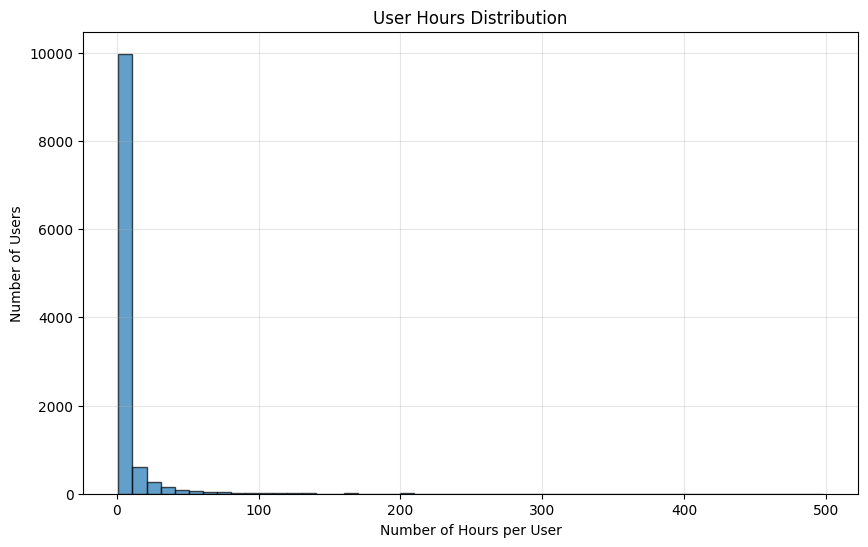

In [7]:
def analyze_user_rating_distribution(user_game_matrix):
    """
    Analyze how many hours each user has
    """
    user_game_matrix = user_game_matrix.applymap(lambda x: min(x, 100))  # Cap at 100 hours

    user_hours_counts = (user_game_matrix > 0).sum(axis=1)
    
    print("USER HOURS DISTRIBUTION ANALYSIS:")
    print("="*50)
    print(f"Total users: {len(user_hours_counts)}")
    print(f"Total games: {user_game_matrix.shape[1]}")
    print(f"Matrix sparsity: {(user_game_matrix == 0).sum().sum() / (user_game_matrix.shape[0] * user_game_matrix.shape[1]) * 100:.1f}%")
    
    print(f"Hours counts per user:")
    print(f"Minimum: {user_hours_counts.min()}")
    print(f"Average: {user_hours_counts.mean():.1f}")
    print(f"Median: {user_hours_counts.median()}")
    print(f"Maximum: {user_hours_counts.max()}")
    
    print(f"\nUsers by rating count:")
    for threshold in [1, 2, 3, 5, 10, 20]:
        count = (user_hours_counts >= threshold).sum()
        percentage = count / len(user_hours_counts) * 100
        print(f"≥ {threshold:2d} Hours: {count:4d} users ({percentage:5.1f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(user_hours_counts, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Hours per User')
    plt.ylabel('Number of Users')
    plt.title('User Hours Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return user_hours_counts

# Run the analysis
rating_counts = analyze_user_rating_distribution(user_game_matrix)
# Choose min rating = 2 (better representation) as our threshold

### **2. Code Implementation - Collaborative Filtering**

**i. Filter users with too few ratings**

In [52]:

def filter_users_with_min_ratings(user_game_matrix, min_ratings=5):
    user_rating_counts = (user_game_matrix > 0).sum(axis=1)
    filtered_users = user_rating_counts[user_rating_counts >= min_ratings].index
    filtered_matrix = user_game_matrix.loc[filtered_users]
    print(f"Filtered from {len(user_game_matrix)} to {len(filtered_matrix)} users")
    return filtered_matrix

**ii. Train/test split**

In [53]:

def create_train_test_split(matrix, min_test_items=3, seed=42):
    np.random.seed(seed)
    train = matrix.copy()
    test = pd.DataFrame(0, index=matrix.index, columns=matrix.columns)

    for user in matrix.index:
        rated_items = matrix.loc[user][matrix.loc[user] > 0].index
        if len(rated_items) > min_test_items:
            test_items = np.random.choice(rated_items, size=min_test_items, replace=False)
            train.loc[user, test_items] = 0
            test.loc[user, test_items] = matrix.loc[user, test_items]

    print(f"Train/test split done — active test users: {(test.sum(axis=1) > 0).sum()}")
    return train, test


**iii. Metrics**

In [54]:
def rmse(pred, true):
    mask = (true > 0)
    return np.sqrt(np.mean((pred[mask] - true[mask])**2))

def mae(pred, true):
    mask = (true > 0)
    return np.mean(np.abs(pred[mask] - true[mask]))


def precision_recall_at_k(pred_matrix, test_matrix, k=10):
    precisions, recalls = [], []
    for u in range(test_matrix.shape[0]):
        test_items = np.where(test_matrix[u, :] > 0)[0]
        if len(test_items) == 0:
            continue
        top_k = np.argsort(pred_matrix[u, :])[::-1][:k]
        hits = len(set(top_k) & set(test_items))
        precisions.append(hits / k)
        recalls.append(hits / len(test_items))
    return np.mean(precisions) if precisions else np.nan, np.mean(recalls) if recalls else np.nan


def ndcg_at_k(pred_matrix, test_matrix, k=10):
    ndcgs = []
    for u in range(test_matrix.shape[0]):
        test_items = np.where(test_matrix[u, :] > 0)[0]
        if len(test_items) == 0:
            continue
        top_k = np.argsort(pred_matrix[u, :])[::-1][:k]
        dcg = np.sum([1 / np.log2(i + 2) for i, item in enumerate(top_k) if item in test_items])
        idcg = np.sum([1 / np.log2(i + 2) for i in range(min(len(test_items), k))])
        ndcgs.append(dcg / idcg)
    return np.mean(ndcgs) if ndcgs else np.nan


**iv. Compute similarity matrix**


In [55]:
def compute_user_similarity(matrix_centered, metric='cosine'):
    if metric == 'cosine':
        sim = cosine_similarity(matrix_centered)
    elif metric == 'euclidean':
        dist = euclidean_distances(matrix_centered)
        sim = 1 / (1 + dist)
    elif metric == 'pearson':
        sim = fast_pearson_similarity(matrix_centered)
    else:
        raise ValueError("Invalid similarity metric")
    return pd.DataFrame(sim, index=matrix_centered.index, columns=matrix_centered.index)

def fast_pearson_similarity(matrix):
    X = matrix.values
    mean_user = X.mean(axis=1, keepdims=True)
    X_centered = X - mean_user
    numerator = X_centered @ X_centered.T
    denom = np.linalg.norm(X_centered, axis=1)
    denominator = np.outer(denom, denom)
    denominator[denominator == 0] = 1e-8
    return numerator / denominator

**v. Predict ratings using top-k neighbors**

In [56]:
def predict_ratings(train_matrix, sim_df, k=10):
    matrix_centered = train_matrix.sub(train_matrix.mean(axis=1), axis=0).fillna(0)
    preds = np.zeros(matrix_centered.shape)
    for i, user in enumerate(train_matrix.index):
        sim_scores = sim_df.loc[user].sort_values(ascending=False)[1:k+1]
        neighbors = sim_scores.index
        weighted_sum = np.dot(sim_scores.values, matrix_centered.loc[neighbors].values)
        preds[i, :] = weighted_sum / (sim_scores.abs().sum() + 1e-9) + train_matrix.loc[user].mean()
    return preds

**vi. Main evaluation loop**


In [ ]:
def find_optimal_k_auto(user_game_matrix, max_k=30, step=5, min_test_items=3, min_ratings=5):
    filtered = filter_users_with_min_ratings(user_game_matrix, min_ratings)
    train, test = create_train_test_split(filtered, min_test_items)

    results = []
    train_np, test_np = train.values, test.values
    sims = ['cosine', 'pearson', 'euclidean']

    for sim in sims:
        print(f"\nComputing {sim} similarity...")
        matrix_centered = train.sub(train.mean(axis=1), axis=0).fillna(0)
        sim_df = compute_user_similarity(matrix_centered, sim)

        for k in range(5, max_k + 1, step):
            pred_matrix = predict_ratings(train, sim_df, k)

            result = {
                'similarity': sim,
                'k': k,
                'RMSE': rmse(pred_matrix, test_np),
                'MAE': mae(pred_matrix, test_np),
                'P@5': precision_recall_at_k(pred_matrix, test_np, k=5)[0],
                'R@5': precision_recall_at_k(pred_matrix, test_np, k=5)[1],
                'P@10': precision_recall_at_k(pred_matrix, test_np, k=10)[0],
                'R@10': precision_recall_at_k(pred_matrix, test_np, k=10)[1],
                'NDCG@10': ndcg_at_k(pred_matrix, test_np, k=10)
            }
            results.append(result)
            print(f"{sim}, k={k} → RMSE={result['RMSE']:.4f}, P@10={result['P@10']:.4f}")

    df = pd.DataFrame(results)
    if not df.empty:
        best = df.loc[df['P@10'].idxmax()]
        print("\nOptimal configuration:")
        print(best)
    else:
        best = None
        print("\nNo valid results found.")
    return df, best


**vii. User-based collaborative filtering**

In [58]:
def user_based_collaborative_filtering(matrix, target_user, n_similar_users=10, similarity_metric='cosine'):
    """
    User-User Collaborative Filtering
    
    Parameters:
        matrix (DataFrame): user-item rating matrix
        target_user: user id (must exist in matrix)
        n_similar_users (int): number of neighbors
        similarity_metric (str): 'cosine', 'euclidean', 'pearson'
        
    Returns:
        recommendations (list of tuples): [(item, predicted_rating), ...] top 10
        predicted_ratings (dict): {item: predicted_rating, ...} for all items
    """
    if target_user not in matrix.index:
        return [], {}

    # 1️Mean-center per user
    matrix_centered = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)

    # 2️Compute similarity
    if similarity_metric == 'cosine':
        sim = cosine_similarity(matrix_centered)
    elif similarity_metric == 'euclidean':
        dist = euclidean_distances(matrix_centered)
        sim = 1 / (1 + dist)
    elif similarity_metric == 'pearson':
        sim = matrix_centered.T.corr().fillna(0).values
    else:
        raise ValueError("similarity_metric must be 'cosine', 'euclidean', or 'pearson'")

    sim_df = pd.DataFrame(sim, index=matrix.index, columns=matrix.index)

    # 3️Find top-n similar users
    similar_users = sim_df[target_user].sort_values(ascending=False)[1:n_similar_users+1]

    # 4️Weighted prediction
    weighted_sum = np.dot(similar_users.values, matrix_centered.loc[similar_users.index].values)
    norm_factor = similar_users.abs().sum()
    preds = weighted_sum / (norm_factor + 1e-9)

    # Convert to Series with proper index
    preds = pd.Series(preds, index=matrix.columns)

    # Add back user's mean
    preds += matrix.loc[target_user].mean()

    # Remove already played/rated items
    played = matrix.loc[target_user][matrix.loc[target_user] > 0].index
    preds = preds.drop(played, errors='ignore')

    # Top 10 recommendations
    recommendations = list(preds.sort_values(ascending=False).head(10).items())

    return recommendations, preds.to_dict()


**viii. Results**

In [59]:
results_df, best_result = find_optimal_k_auto(user_game_matrix, max_k=30, step=5)

Filtered from 11350 to 2436 users
Train/test split done — active test users: 2436

Computing cosine similarity...
cosine, k=5 → RMSE=1.8082, P@10=0.0301
cosine, k=10 → RMSE=1.7912, P@10=0.0365
cosine, k=15 → RMSE=1.7796, P@10=0.0411
cosine, k=20 → RMSE=1.7717, P@10=0.0441
cosine, k=25 → RMSE=1.7660, P@10=0.0460
cosine, k=30 → RMSE=1.7602, P@10=0.0488

Computing pearson similarity...
pearson, k=5 → RMSE=1.8078, P@10=0.0301
pearson, k=10 → RMSE=1.7912, P@10=0.0365
pearson, k=15 → RMSE=1.7796, P@10=0.0411
pearson, k=20 → RMSE=1.7717, P@10=0.0441
pearson, k=25 → RMSE=1.7660, P@10=0.0460
pearson, k=30 → RMSE=1.7602, P@10=0.0488

Computing euclidean similarity...
euclidean, k=5 → RMSE=1.8394, P@10=0.0275
euclidean, k=10 → RMSE=1.8408, P@10=0.0303
euclidean, k=15 → RMSE=1.8422, P@10=0.0341
euclidean, k=20 → RMSE=1.8426, P@10=0.0351
euclidean, k=25 → RMSE=1.8436, P@10=0.0383
euclidean, k=30 → RMSE=1.8442, P@10=0.0404

Optimal configuration:
similarity      cosine
k                   30
RMSE   

In [60]:
print("Final results:")
summary_table = results_df[["similarity", "k", "RMSE", "MAE", "P@5", "R@5", "P@10", "R@10", "NDCG@10"]]
summary_table = summary_table.round(4)
print(summary_table.to_markdown(index=False))

Final results:
| similarity   |   k |   RMSE |    MAE |    P@5 |    R@5 |   P@10 |   R@10 |   NDCG@10 |
|:-------------|----:|-------:|-------:|-------:|-------:|-------:|-------:|----------:|
| cosine       |   5 | 1.8082 | 0.9823 | 0.0314 | 0.0523 | 0.0301 | 0.1003 |    0.0574 |
| cosine       |  10 | 1.7912 | 0.9732 | 0.0388 | 0.0647 | 0.0365 | 0.1215 |    0.071  |
| cosine       |  15 | 1.7796 | 0.966  | 0.0449 | 0.0748 | 0.0411 | 0.1368 |    0.0797 |
| cosine       |  20 | 1.7717 | 0.9619 | 0.0474 | 0.079  | 0.0441 | 0.1471 |    0.0856 |
| cosine       |  25 | 1.766  | 0.959  | 0.0498 | 0.0831 | 0.046  | 0.1534 |    0.0899 |
| cosine       |  30 | 1.7602 | 0.9563 | 0.0522 | 0.087  | 0.0488 | 0.1627 |    0.0954 |
| pearson      |   5 | 1.8078 | 0.9821 | 0.0314 | 0.0524 | 0.0301 | 0.1004 |    0.0575 |
| pearson      |  10 | 1.7912 | 0.9732 | 0.0389 | 0.0649 | 0.0365 | 0.1215 |    0.071  |
| pearson      |  15 | 1.7796 | 0.966  | 0.0451 | 0.0751 | 0.0411 | 0.1368 |    0.0797 |
| pear

In [61]:
best_result

similarity      cosine
k                   30
RMSE          1.760167
MAE           0.956279
P@5           0.052217
R@5           0.087028
P@10           0.04881
R@10          0.162698
NDCG@10       0.095425
Name: 5, dtype: object

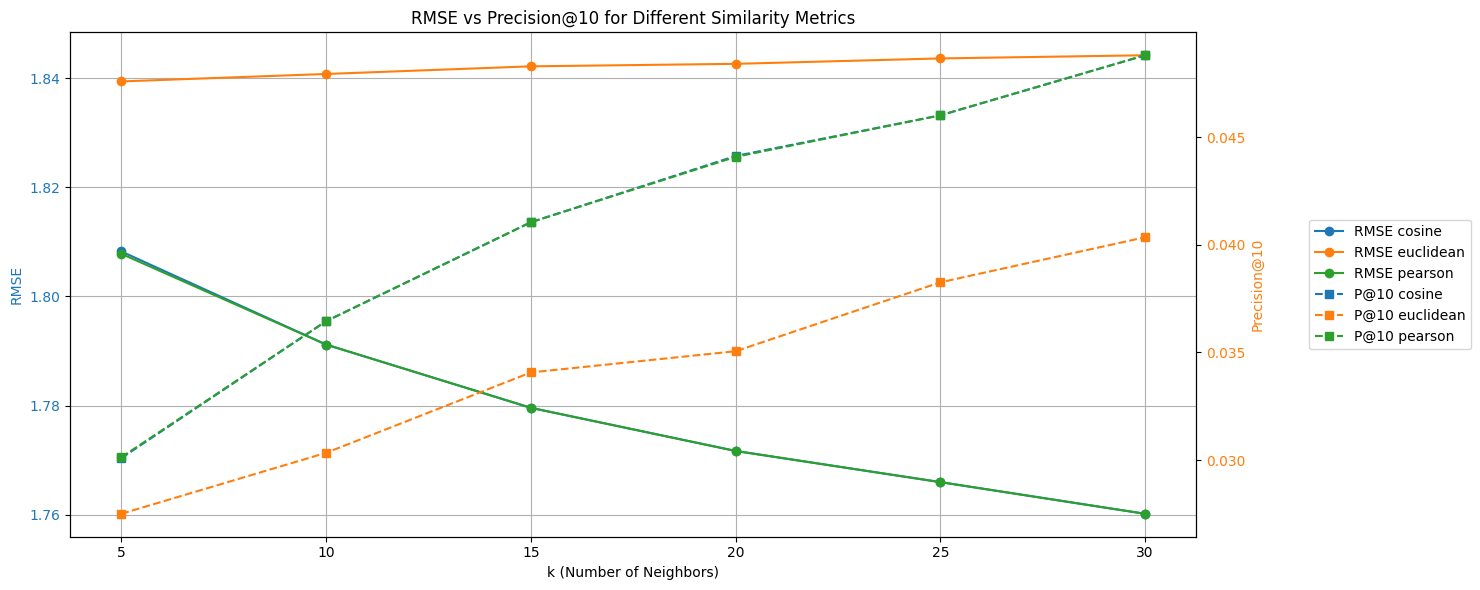

In [62]:

# Pivot the table
rmse_df = results_df.pivot(index='k', columns='similarity', values='RMSE')
p10_df = results_df.pivot(index='k', columns='similarity', values='P@10')

k_values = rmse_df.index

fig, ax1 = plt.subplots(figsize=(15,6))

# Left y-axis: RMSE
ax1.set_xlabel('k (Number of Neighbors)')
ax1.set_ylabel('RMSE', color='tab:blue')
for sim in rmse_df.columns:
    ax1.plot(k_values, rmse_df[sim], marker='o', label=f'RMSE {sim}')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: Precision@10
ax2 = ax1.twinx()
ax2.set_ylabel('Precision@10', color='tab:orange')
for sim in p10_df.columns:
    ax2.plot(k_values, p10_df[sim], marker='s', linestyle='--', label=f'P@10 {sim}')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', bbox_to_anchor=(1.25, 0.5))

plt.title('RMSE vs Precision@10 for Different Similarity Metrics')
ax1.grid(True)
fig.tight_layout()
plt.show()


In [63]:
# Pick target user (first user in the matrix for example)
target_user = user_game_matrix.index[0]

# Suppose best_result is a row from results_df with the best k & similarity
best_k = int(best_result['k'])
best_metric = best_result['similarity']  # matches your column name

# Run user-based CF
recommendations, predicted = user_based_collaborative_filtering(
    user_game_matrix,
    target_user=target_user,
    n_similar_users=best_k,
    similarity_metric=best_metric
)

# Print results nicely
print(f"\nRecommended games for userid: {target_user} (using {best_metric} similarity, k={best_k})")
print(f"{'Game':40s} {'Predicted Rating':>15s}")
print("-"*55)
for game, rating in recommendations:
    print(f"{game:40s} {rating:15.2f}")



Recommended games for userid: 5250 (using cosine similarity, k=30)
Game                                     Predicted Rating
-------------------------------------------------------
Prison Architect                                    0.14
Euro Truck Simulator 2                              0.14
Banished                                            0.12
Age of Empires II HD Edition                        0.12
Half-Life 2                                         0.11
ARK Survival Evolved                                0.11
DayZ                                                0.11
WWE 2K15                                            0.11
NBA 2K16                                            0.11
PAYDAY 2                                            0.10


🧠 Parameter Effects

k (Number of Neighbors): Increasing k generally reduces RMSE slightly at first because more neighbors give a smoother estimate. However, after a certain point, precision@10 can drop, because less similar neighbors introduce noise in top recommendations.

Similarity Metric:

Cosine: Works well when rating scales vary between users. Tends to favor users with similar relative preferences, good balance for RMSE and precision.

Pearson: Normalizes for user rating bias, often slightly improves RMSE but may have mixed effect on top-N precision.

Euclidean: Sensitive to scale differences; can perform worse in sparse, skewed rating matrices like Steam.

Overall, there is a tradeoff: higher k may improve RMSE but reduce top-N recommendation quality (Precision@10).

✅ Best Configuration

Best Setting: k = 30, Similarity = Cosine 
Metrics: RMSE = 1.7601, Precision@10 = 0.04881

Observation: Cosine similarity captures user preference patterns well, and k=30 provides enough neighbors for stable predictions without introducing too much noise into top-10 recommendations.

💬 Strengths and Weaknesses

Strengths:

Simple and intuitive; easy to implement.

Works well for dense subsets of the data where users share many common games.

Can capture personalized tastes without model training.

Weaknesses:

Sensitive to sparsity: most users rate only a small fraction of games, so similarity estimates can be noisy.

Performance drops for users with few ratings (cold start).

Computationally expensive for large numbers of users.